### Adm Details

Name    : Brian Mutugi <br />
Adm No. : 151174<br />
Title   : Exracting Exam Questions From Images of Question Papers  
MSc Data Science and Analytics, Strathmore University

### System Architecture

<img src="images/solution.png" alt="Targeted Solution" width="40%" />

The focus of this project will be the 'Questions ML model' the other sections and functionalities will be tackled at later stages of the research.

### Methodology

To achieve the goal of this project, we are going to adopt the CRISP-DM Methodology which shall involve the following steps:

<i><ol>
<li>Business Understanding - Outlining the problem set and the main objective - <b>Done</b></li>
<li>Data Understanding - Highlighting the source of data to be used in model training and evaluation - <b>Done</b></li>
<li>Data Preparation - Processing and transforming the data to a format that is more model-friendly - <b>Done</b></li>
<li>Data Modelling - Training several machine learning algorithms (Traditional and Modern) to classify text as question or not - <b>Done</b></li>
<li>Model Optimization - Balancing between performance and resource consumption of our main model(BERT) - <b>Done</b></li>
<li>Model Evaluation - Using new text data extracted from images to ascertain the results of the models are as expected - <b>Done</b></li>
<li>Model Comparison and Selection - Using model performance metrics to rank the appropriateness of the models - <b>Done</b></li>
<li>Model Deployment - Setting an online platform through which users can interact with the  model - <b>Done</b></li>
</ol></i>


### Step 1 : Business Understanding

Most exams in Kenyan secondary to higher learning institutions are hand-written, they are then assessed by the lectures/teacher who then, individually decide the score for each answer and collectively for each paper. The process is long and strenuous, taking a lot of energy and time for the educators. For the students, the time taken for assessment reduces the quality and quantity of attention they get from their lecturers/teachers; the results too, considering the human element, might also be biased and inaccuracte. For institutions, learning calendars and the quality of learning experiences are negatively affected.

This can be improved through artificial intelligence, specifically by incoporating machine learning models and pretrained large language models in models. They can be faster, use a wider knowledge base and be a more standard evaluation approach especially for fact-based theoretical examinations.

Smartphone usage penetration in the country is quite decent, these phones are equipped with decent cameras and internet browsers - conduits to utilization of deployed machine learning solutions. The smartphones can be used to take photos of the examinations and answers then uploaded through the deployed solutions, from which assements and results would be relayed back to the assessors.

One of the most critical step for machine learning involvement is the extractiong of questions from the photos of examination question papers, with just that, it would actually be possible to generate marking schemes. The ideas is to then couple this with answer this with question extract and the results of this pair is what would then be passed to pretrained models such as GPT 4 for evaluation.

The focus of this project is to successfully extract/classify questions from images exam question papers.  
<b>Hypothesis:</b> Machine Learning models can be used to determine if a particular line of text is a question or not in the processs of exam marking automation. 

### Step 2 : Data Understanding

For any machine learning task, appropriate, sufficient and clean data is neccesary.

This task is going to be using a 1800 row - csv file of text that has been extracted from exams and labelled as either a question or not.

Let's look at the data:

In [1]:
# Import the neccesary libraries
import pandas as pd

# Load data
df = pd.read_csv('labelled_text.csv')

# Shuffle the dataframe rows
df = df.sample(frac=1).reset_index(drop=True)

#look at the first five rows
df.head()

,text,is_question,label
0,It was a sunny day in Paris. They went for a l...,0.0,No
1,SCHOOL OF COMPUTING AND INFORMATION TECHNOLOGY,0.0,tbd
2,MASTER OF SCIENCE IN DATA SCIENCE AND ANALYTICS,0.0,tbd
3,(i) State FOUR importance of personal hygiene ...,1.0,tbd
4,63. Define the key concepts of Physics. (10 Ma...,1.0,Yes


<i>The data has three columns, text, is_question and label, text and is_question are the most important columns</i>

The data has now been loaded let's look at it's shape:

In [2]:
#Show the rows and columns of the data
df.shape

(1809, 3)

<i>The data has 1809 rows and 3 columns - sufficient for training.</i>

Let's looks at its statistical properties:

In [3]:
#generate the statistical properties of the data:
df.describe()

,is_question
count,1804.000000
mean,0.449002
std,0.497530
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Step 3 : Data Preparation

##### Step 3.1 : Dealing with Null Values

First of all, we need to look for null values in the data that might mislead models and cause errors:

In [4]:
#Look for null values in each column
print(df.isnull().sum())

text           6
is_question    5
label          1
dtype: int64


<i>There are missing/null values in each of the columns: 7 in text, 5 for is_question and 1 for label. The numbers are not worrying, we can drop the rows with null values with a minimal effect on the size of the dataset.</i>

In [5]:
#drop rows with null values
df.dropna(inplace=True)

#Check for null values again
print(df.isnull().sum())

text           0
is_question    0
label          0
dtype: int64


In [6]:
#Show the rows and columns of the data
df.shape

(1800, 3)

<i>The are missing/null values have now been removed.</i>

##### Step 3.2 : Dealing with column formats

We now need to look to at the target variable: is_question, the data type should either be 0 or 1.

Previously however, on the data understanding section, the format appeared to be a float 1.0, 0.0, we need to change the format to integer:

In [7]:
#Convert float to int
df['is_question'] = df['is_question'].astype(int)

#Look at the dataframe again
df.head()

,text,is_question,label
0,It was a sunny day in Paris. They went for a l...,0,No
1,SCHOOL OF COMPUTING AND INFORMATION TECHNOLOGY,0,tbd
2,MASTER OF SCIENCE IN DATA SCIENCE AND ANALYTICS,0,tbd
3,(i) State FOUR importance of personal hygiene ...,1,tbd
4,63. Define the key concepts of Physics. (10 Ma...,1,Yes


<i>The format of our target attribute: is question has been succesfully converted from float to integer.</i>

##### Step 3.3 : Feature Engineering

Our dataframe has one text column, however to have an effective modelling progress, we need to extract some characteristics from the main text.
These characteristics will be added as new columns and will inform the machine learning algorithms too.


The characteristics that are important in determining if a text is question or not include:
<ol>
<li>If the text has a prompt word e.g. explain, define, describe</li>
<li>If the text starts with indexing characters e.g. i), 1., a) </li>
<li>If the text end with marks characters e.g. ks), ks}, ks] </li>
<li>If the text ends with a lowercase or uppercase character </li>
<li>If the text contains 'question' in it</li>
</ol>

Lets generate the features from the 'text' column:

In [8]:
#Importing the neccesary libraries
import re
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
def extract_attributes(text):
    # List of prompt words
    prompt_words = ["what", "why", "when", "where", "explain", "describe", "give", "how", "discuss", "write", "define","do","analyze","compare"]

    # First word, ignoring leading spaces and converting to lowercase for case-insensitive comparison
    clean_line = text.strip()

    # Split the line into words
    words = clean_line.split()

    second_word = ""
    # Check if there are at least three words to get the word between the first and second space
    if len(words) >= 3:
        second_word = words[1]  # This is the word between the first and second spaces
    else:
        second_word = ""

    first_word = clean_line.split()[0].lower() if text.strip() else ""
    single_word = int(len(text.split()) == 1) if text else 0

    # Check if the first word is a prompt word
    starts_with_prompt_word = int((first_word.lower() in prompt_words) or (second_word.lower() in prompt_words))
    contains_prompt_word = int(any(pw in text.lower() for pw in prompt_words))


    # Refined patterns for 'indexed_start'
    patterns = [
        r"^\(?[a-zA-Z]\)\s",    # Matches patterns like (a) , b) 
        r"^\d+\.\s",            # Matches patterns like 1. 
        r"^\(?[ivxlcdm]+\)\s",  # Matches patterns like (i) , ii) 
    ]
    # Check the pattern against the first 1 to 5 characters of the text
    indexed_start = int(any(re.match(pattern, text.strip()[:7]) for pattern in patterns))

    question_start = int(first_word == "question")
    last_four_chars = text[-4:] if len(text) >= 4 else text
    last_q_chars = ["ks) ","rks) ","mks) ","ks] ","rks] ","mks] ","ks} ","rks} ","mks} ","ks)","rks)","mks)","ks]","rks]","mks]","ks}","rks}","mks}"]
    # ends_with_ks = int(last_four_chars == "ks) " or last_four_chars == "rks)"  or last_four_chars == "mks)")
    ends_with_ks = int(any(text.endswith(q_char) for q_char in last_q_chars))
    contains_ks = int(any(q_char in text for q_char in last_q_chars))
    lower_start = int(text.strip()[0].islower()) if text.strip() else 0
    upper_start = int(text.strip()[0].isupper()) if text.strip() else 0

    return first_word, indexed_start, question_start, last_four_chars, ends_with_ks, contains_ks, lower_start, upper_start, contains_prompt_word, starts_with_prompt_word, single_word



# Reapply the updated function to the dataframe
df[['first_word', 'indexed_start', 'question_start', 'last_four_chars', 'ends_with_ks','contains_ks', 'lower_start', 'upper_start','contains_prompt_word','starts_with_prompt_word','single_word']] = \
    df['text'].apply(lambda x: pd.Series(extract_attributes(x)))

# Shuffle the dataframe
df = shuffle(df, random_state=42)

#Save the feature generated dataset to csv
df.to_csv('feature_generated.csv')


# Transform the target variable to numeric(vectorizing) for easy processing by ML Models
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['text'])

# Display the updated dataframe
df.head()

,text,is_question,label,first_word,indexed_start,question_start,last_four_chars,ends_with_ks,contains_ks,lower_start,upper_start,contains_prompt_word,starts_with_prompt_word,single_word
1600,112. Outline the key concepts of Mathematics. ...,1,Yes,112.,1,0,rks),1,1,0,0,0,0,0
948,LIII) Explain the key concepts of Mathematics....,1,Yes,liii),0,0,rks),1,1,0,1,1,1,0
874,NDNA Teun NANG aaa po aey EN c,0,tbd,ndna,0,0,EN c,0,0,0,1,0,0,0
163,Cells are the basic building blocks of all mks...,0,no,cells,0,0,isms,0,0,0,1,0,0,0
1279,Calculus allows ks) the calculation of change ...,0,no,calculus,0,0,tion,0,1,0,1,0,0,0


<i>The important characteristics/features have now be generated and can now be used in the modelling phase.</i>

### Step 4 : Modelling

In this particular step, we are going to take two approaches to setup binary classification models: is_question (1 or 0)
<ol>
<li>Traditional machine learning approaches: Decision Trees, XGBoost, SVM</li>
<li>Modern approaches: Deeplearning - Tensorflow and Transformers-BERT</li>
<ol>

##### Step 4.1 : Feature Selection

Our target variable is is_question.

Some characteristics are more important than others in determining if some text is a question or not.
In this step we are going to compare and rank the importance of our columns/attributes in determining if a text is a question or not using a correlation matrix and the chi-squared test:

In [10]:
#Importing the neccesary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the default figure size
plt.rcParams['figure.figsize'] = [6, 3]

# Set the global theme for Seaborn
sns.set_theme(
    style='whitegrid',  # Sets the background to white grid
    palette='deep',     # Sets the color palette
    font='sans-serif',  # Sets the font to sans-serif
    font_scale=1.25,    # Scales up the font size by 25%
    color_codes=True,   # Allow the use of shorthand color codes
    rc={"figure.figsize": (6, 3)}  # Sets the default figure size
)


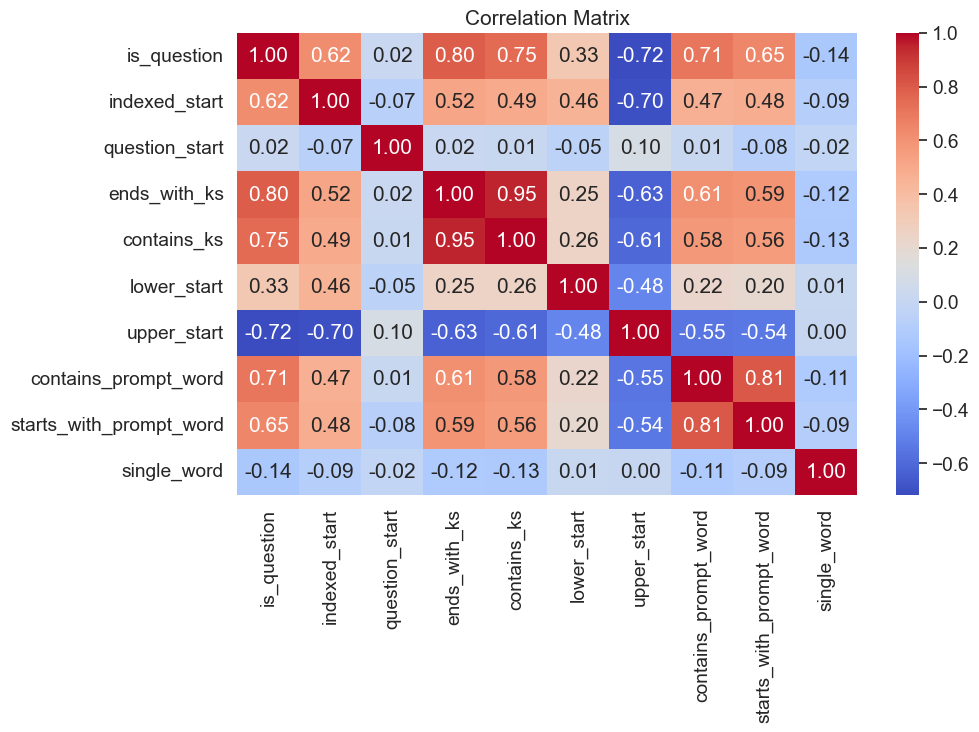

In [11]:
# Ensure boolean columns are in integer format for correlation analysis
bool_cols = ['indexed_start', 'question_start', 'ends_with_ks','contains_ks', 'lower_start', 'upper_start','contains_prompt_word','single_word']
df[bool_cols] = df[bool_cols].astype(int)

# Compute correlation matrix
correlation_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Recommendations for best features to predict 'is_question' based on correlation
correlation_with_target = correlation_matrix['is_question'].sort_values(ascending=False)
best_features = correlation_with_target.index[1:]  # Exclude 'is_question' itself
best_features_recommendations = best_features[:3]  # Top 3 features

Determining the most important features using Chi-squared:

In [12]:
#Importing the neccesary libraries
from sklearn.feature_selection import SelectKBest, chi2

In [13]:
# Preparing the dataset for feature selection
X = df.drop(['text', 'is_question', 'label', 'first_word', 'last_four_chars'], axis=1)
y = df['is_question']

# Apply SelectKBest class to extract top features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concatenating two dataframes for better visualization 
featureScores = pd.concat([df_columns,df_scores],axis=1)
featureScores.columns = ['Feature','Score']  # Naming the dataframe columns
featureScores = featureScores.sort_values(by='Score', ascending=False)

# Display the top features based on score
featureScores.head(10)  

,Feature,Score
2,ends_with_ks,582.034261
6,contains_prompt_word,570.839151
7,starts_with_prompt_word,550.402381
0,indexed_start,527.231511
3,contains_ks,490.860826
5,upper_start,355.469105
4,lower_start,175.090555
8,single_word,32.727273
1,question_start,0.512159


<i>The important characteristics/features are ends_with_ks,contains_prompt_word,starts_with_prompt_word, indexed_start and upper_start.</i>

Selecting the important features/columns for easier referencing:

In [14]:
selected_features  = ['contains_prompt_word','starts_with_prompt_word','ends_with_ks', 'indexed_start', 'lower_start', 'upper_start']

##### Step 4.2 : Traditional Machine Learning Algorithms

Step 4.2.1 : Decision Trees

In [15]:
#Importing the neccesary libraries
import os
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump
import pickle

Training the model

In [16]:
# Other selected features
X_other = df[selected_features]

# Convert X_other to a dense array if it's not already
X_other_dense = X_other.to_numpy()

# Combine the text features with other selected features
# Convert the sparse matrix to a dense matrix
X_combined = hstack([X_text, X_other_dense]).toarray()

# Splitting the combined dataset: 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train a Decision Tree model with the combined features
DTmodel = DecisionTreeClassifier()
DTmodel.fit(X_train, y_train)

DecisionTreeClassifier()

Testing and Visualizing the DT Model's performance:

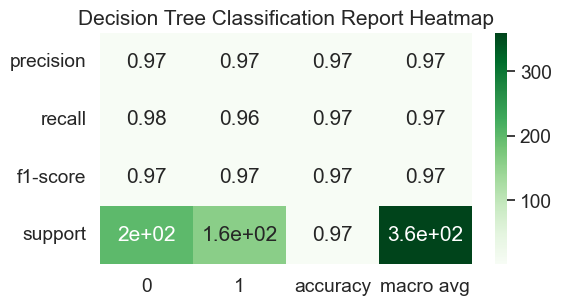

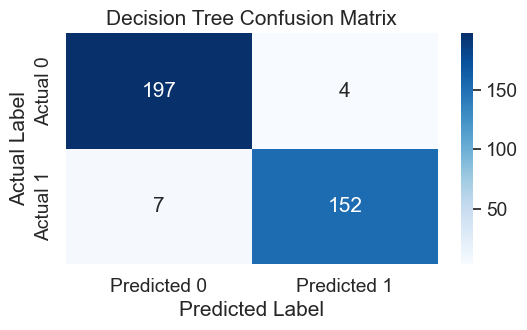

In [17]:
# Evaluate the model
y_pred = DTmodel.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert report to pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Plotting the classification report heatmap
plt.figure()
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Greens')
plt.title('Decision Tree Classification Report Heatmap')
plt.yticks(rotation=0)
plt.show()

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Decision Tree Confusion Matrix')
plt.show()

<i>The Decision Tree model shows decent performance</i>

Saving the model:

In [18]:
# Save the model using pickle
model_path = os.path.join('models', 'DTModel.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(DTmodel, file)

Step 4.2.3 : Logistic Regression

In [19]:
#Importing the neccesary libraries
from sklearn.linear_model import LogisticRegression

Training the model:

In [20]:
# use the selected features
X = df[selected_features]
y = df['is_question']

# Combine the text features with other selected features
X_combined = hstack([X_text, X])

# Splitting the combined dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train the logistic regression model
LRmodel = LogisticRegression(max_iter=1000)  # Increase max_iter if needed
LRmodel.fit(X_train, y_train)

# Evaluate the model
y_pred = LRmodel.predict(X_test)

Testing and Visualizing the DT Model's performance:

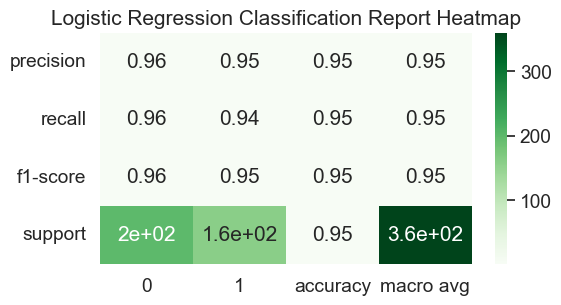

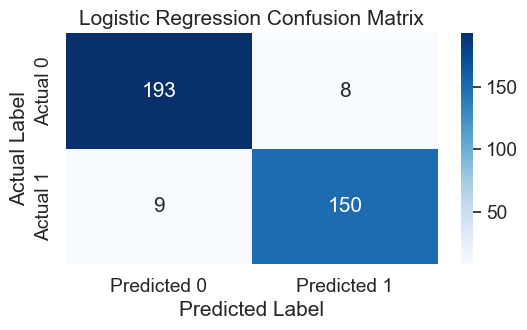

In [21]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert report to pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Plotting the classification report heatmap
plt.figure()
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Greens')
plt.title('Logistic Regression Classification Report Heatmap')
plt.yticks(rotation=0)
plt.show()

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

Saving the model:

In [22]:
# Save the model using pickle
model_path = os.path.join('models', 'LRModel.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(LRmodel, file)

Step 4.2.3 : XGBoost

In [23]:
#Importing the neccesary libraries
from xgboost import XGBClassifier

Training the model:

In [24]:
# Other selected features
X_other = df[selected_features].to_numpy()

# Combine the text features with other selected features
X_combined = hstack([X_text, X_other])

# Splitting the combined dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train an XGBoost model with the combined features
XGBmodel = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
XGBmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Testing and Visualizing the XGBoost model's performance:

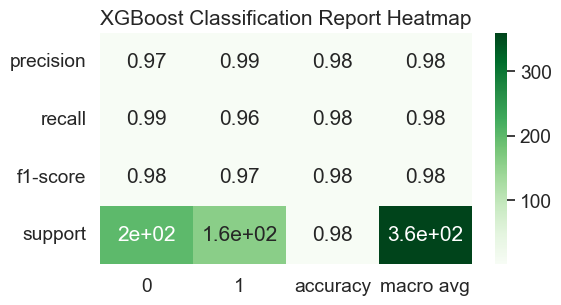

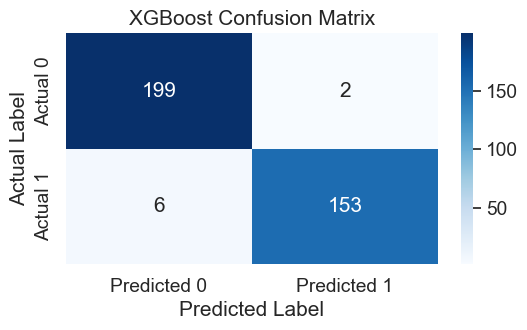

In [25]:
# Evaluate the model
y_pred = XGBmodel.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert report to pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Plotting the classification report heatmap
plt.figure()
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Greens')
plt.title('XGBoost Classification Report Heatmap')
plt.yticks(rotation=0)
plt.show()

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

<i>The XGBoost model shows very good performance</i>

Saving the model:

In [26]:
# Save the model using pickle
model_path = os.path.join('models', 'XGBModel.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(XGBmodel, file)

Step 4.2.4 : SVM

In [27]:
from sklearn.svm import SVC

Training the model

In [28]:
# Choose the important features
X_other = df[selected_features].to_numpy()

# Combine the text features with other selected features
X_combined = hstack([X_text, X_other])

# Splitting the combined dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train an SVM model with the combined features
SVMmodel = SVC()
SVMmodel.fit(X_train, y_train)

SVC()

Testing and Visualizing the DT Model's performance:

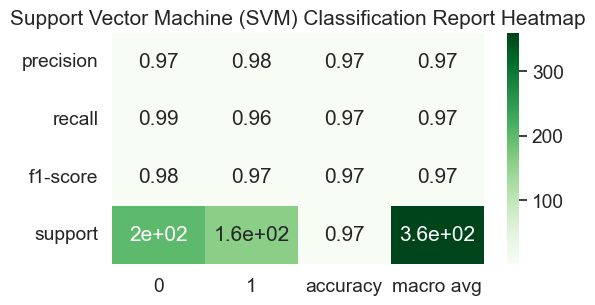

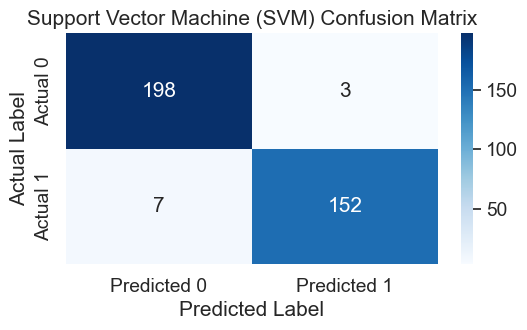

In [29]:
# Evaluate the model
y_pred = SVMmodel.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert report to pandas DataFrame
report_df = pd.DataFrame(report).transpose()

# Plotting the classification report heatmap
plt.figure()
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Greens')
plt.title('Support Vector Machine (SVM) Classification Report Heatmap')
plt.yticks(rotation=0)
plt.show()

# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Support Vector Machine (SVM) Confusion Matrix')
plt.show()

<i>The SVM model shows very good performance too: best so far on the traditional approaches</i>

Saving the model:

In [30]:
# Save the model using pickle
model_path = os.path.join('models', 'SVMModel.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(SVMmodel, file)

##### Step 4.3 : Modern Approaches

Step 4.3.1 : Deep Learning using keras and tensorflow

In [31]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Training the model:

In [32]:
# Use the important features
X_other = df[selected_features].to_numpy()

# Combine the text features with other selected features
X_combined = hstack([X_text, X_other])

# Splitting the combined dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler(with_mean=False)  # Set with_mean=False for sparse matrix handling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the sparse matrix to a dense matrix
X_train_dense = X_train_scaled.toarray()
X_test_dense = X_test_scaled.toarray()

# Deep Learning model
DLmodel = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
DLmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
DLmodel.fit(X_train_dense, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
45/45 [==============================] - 1s 2ms/step - loss: 0.6048 - accuracy: 0.7465
Epoch 2/10
45/45 [==============================] - 0s 2ms/step - loss: 0.2493 - accuracy: 0.9083
Epoch 3/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1202 - accuracy: 0.9542
Epoch 4/10
45/45 [==============================] - 0s 2ms/step - loss: 0.0700 - accuracy: 0.9806
Epoch 5/10
45/45 [==============================] - 0s 2ms/step - loss: 0.0619 - accuracy: 0.9792
Epoch 6/10
45/45 [==============================] - 0s 2ms/step - loss: 0.0409 - accuracy: 0.9875
Epoch 7/10
45/45 [==============================] - 0s 3ms/step - loss: 0.0340 - accuracy: 0.9889
Epoch 8/10
45/45 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.9896
Epoch 9/10
45/45 [==============================] - 0s 2ms/step - loss: 0.0370 - accuracy: 0.9917
Epoch 10/10
45/45 [==============================] - 0s 2ms/step - loss: 0.0293 - accuracy: 0.9937


Testing and Visualizing the DT Model's performance:

12/12 [==============================] - 0s 936us/step


Accuracy of the Deep Learning model: 97.50%


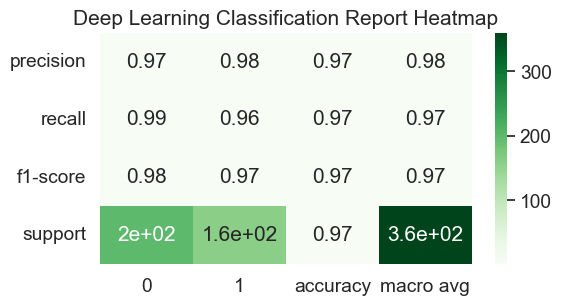

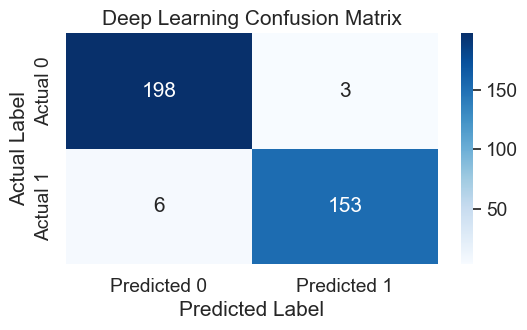

In [33]:
# Evaluate the model
y_pred = (DLmodel.predict(X_test_scaled) > 0.5).astype("int32")

# Classification report and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Deep Learning model: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure()
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Greens')
plt.title('Deep Learning Classification Report Heatmap')
plt.yticks(rotation=0)
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Deep Learning Confusion Matrix')
plt.show()

Saving the model:

In [34]:
# Save the model
model_path = os.path.join('models', 'DLModel')
DLmodel.save(model_path)

INFO:tensorflow:Assets written to: models\DLModel\assets


Step 4.3.1 : Transformers - Fine-tuning BERT

Checking for GPU

In [35]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU not found, found:')
    device_name = 'cpu'
    print(device_name)

GPU not found, found:
cpu


Setting the computational environment, GPU if found else CPU

In [36]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


Taking a quick peek at our data

In [37]:
df.loc[df.is_question == 0].sample(5)[['text', 'is_question']]

,text,is_question
102,He cooked a delicious meal for dinner. Music h...,0
589,The painting was a masterpiece of color and em...,0
300,The speed of light is constant in vacuum ks,0
715,World War II reshaped global power dynamics si...,0
840,‘ ” (Smarks),0


Extracting texts and labels as numpy arrays for training 

In [38]:
# Get the lists of texts and their labels.
texts = df.text.values
labels = df.is_question.values

Loading our tokenizer to split text to tokens then the tokens mapped to index in the tokizer vocab

In [39]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading BERT tokenizer...


Using the tokenizer in  one line to see the output

In [40]:
# Print the original sentence.
print(' Original: ', texts[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(texts[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))

 Original:  112. Outline the key concepts of Mathematics. (10 Marks)
Tokenized:  ['112', '.', 'outline', 'the', 'key', 'concepts', 'of', 'mathematics', '.', '(', '10', 'marks', ')']
Token IDs:  [11176, 1012, 12685, 1996, 3145, 8474, 1997, 5597, 1012, 1006, 2184, 6017, 1007]


Split all lines to tokens, add special tokens and map to their IDs

In [41]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for txt in texts:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        txt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Original:  112. Outline the key concepts of Mathematics. (10 Marks)
Token IDs: [101, 11176, 1012, 12685, 1996, 3145, 8474, 1997, 5597, 1012, 1006, 2184, 6017, 1007, 102]


Looking at the maximum length of our sentences for padding decision

In [42]:
print('Max sentence length: ', max([len(ti) for ti in input_ids]))

Max sentence length:  122


Set the max len to 128 (greater than 122) and apply the padding

In [43]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras_preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 128 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 122...
MAX_LEN = 128

print('\nPadding/truncating all lines of text to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all lines of text to 128 values...

Padding token: "[PAD]", ID: 0

Done.


Setting the attention masks - to indcate which tokens represent words vs those that are just padding

In [44]:
# Create attention masks
attention_masks = []

# For each sentence...
for ti in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in ti]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

Doing the 80-20 Train Test split

In [45]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

Converting the numpy arrays to tensors as expected by the model

In [46]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).to(torch.long)
validation_inputs = torch.tensor(validation_inputs).to(torch.long)

train_labels = torch.tensor(train_labels).to(torch.long)
validation_labels = torch.tensor(validation_labels).to(torch.long)

train_masks = torch.tensor(train_masks).to(torch.long)
validation_masks = torch.tensor(validation_masks).to(torch.long)

Creating an iterator for our dataset to save on memory

In [47]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

Loading pre-trained 'bert-base-uncased' 

In [48]:
'''
Fine-tuning BERT for Text Classification

Now, let's fine-tune our BERT model. We do this by adding a new layer for classification, known as the classifier layer, to our pre-trained model. 
This classifier layer will be trained on our specific task (question binary classification), while the rest of the BERT model will be fine-tuned.

'''

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cpu()

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Browsing all model parameters by name to understand its architecture

In [49]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Loading the optimizer and setting the recommend fine tuning values

In [50]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [51]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Setting a helper function to calculate the accuracy

In [52]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

A  helper function to calculate the elapsed time

In [53]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training!

In [54]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
# torch.cpu.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        


        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     45.    Elapsed: 0:12:37.

  Average training loss: 0.24
  Training epcoh took: 0:14:15

Running Validation...
  Accuracy: 0.99
  Validation took: 0:01:24

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     45.    Elapsed: 0:12:45.

  Average training loss: 0.06
  Training epcoh took: 0:14:20

Running Validation...
  Accuracy: 0.98
  Validation took: 0:01:18

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     45.    Elapsed: 0:12:06.

  Average training loss: 0.04
  Training epcoh took: 0:13:37

Running Validation...
  Accuracy: 0.98
  Validation took: 0:01:21

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     45.    Elapsed: 0:12:04.

  Average training loss: 0.03
  Training epcoh took: 0:13:35

Running Validation...
  Accuracy: 0.98
  Validation took: 0:01:21

Training complete!


Checking the loss over our batches

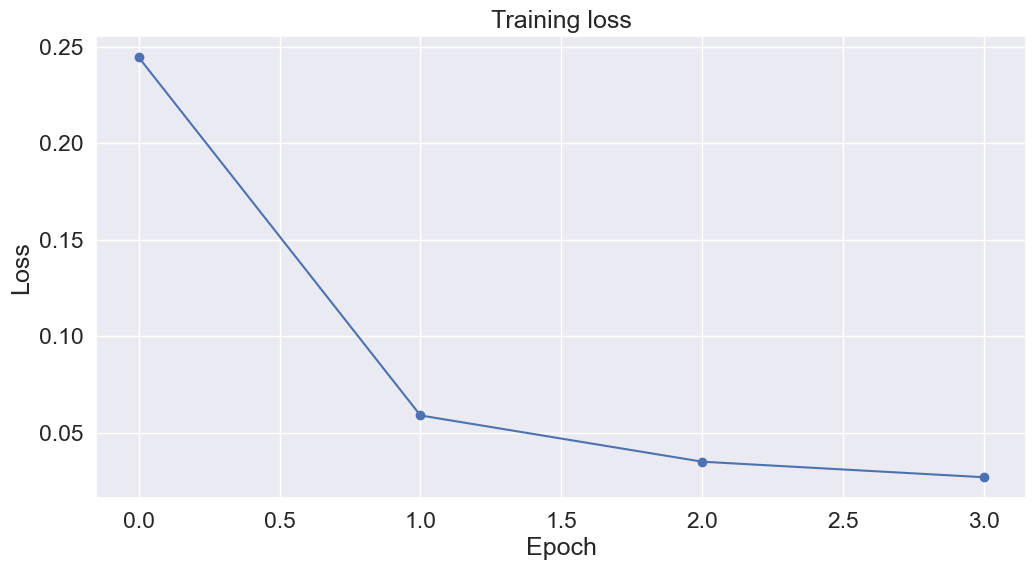

In [55]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

From the graph, The most optimum number of epochs is 1

In [56]:
epochs = 1

Step 4.3.1.2 : Optimization - Retraining BERT using the optimum number of epochs

In [57]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
# torch.cpu.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        


        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("ReTraining complete!")


======== Epoch 1 / 1 ========
Training...
  Batch    40  of     45.    Elapsed: 0:16:04.

  Average training loss: 0.02
  Training epcoh took: 0:17:53

Running Validation...
  Accuracy: 0.98
  Validation took: 0:01:38

ReTraining complete!


Preparing our test data:

In [59]:
# Load the dataset into a pandas dataframe.
test_df = df.tail(400)

# Report the number of sentences.
print('Number of test lines: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
texts = test_df.text.values
labels = test_df.is_question.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for txt in texts:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        txt,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test lines: 400



Applying our fine -tuned model to make predictions on the test dataset:

In [60]:
# Prediction on test set

print('Predicting labels for {:,} test lines...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 400 test lines...


    DONE.


Checking the balance of our test dataset:

In [61]:
print('Positive samples: %d of %d (%.2f%%)' % (test_df.is_question.sum(),len(test_df.is_question), (int(test_df.is_question.sum()) / int(len(test_df.is_question))) * 100.0))

Positive samples: 189 of 400 (47.25%)


The dataset looks balanced

Using Mathews Corelation Coefficient to check accuracy

In [62]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)


matthews_set

Calculating Matthews Corr. Coef. for each batch...


[0.9278305692406299,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9229582069908973,
 0.9379228369755696,
 1.0]

Using MCC for final score:

In [63]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.985


Visualizing the performance metrics of the fine-tuned BERT model:

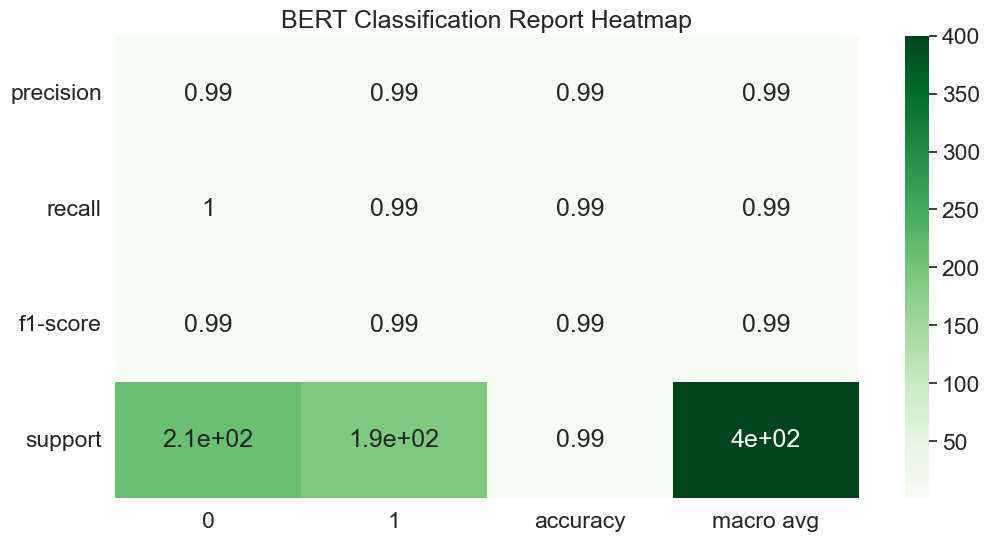

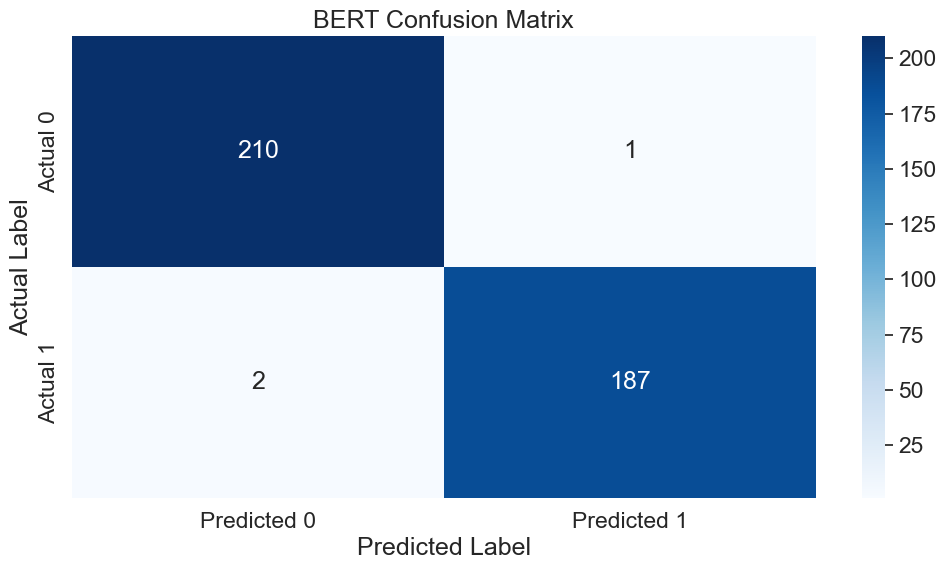

In [64]:

# Combine predictions from each batch into a single list
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to class predictions
predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

### Step 2: Generate classification report
report = classification_report(flat_true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()



### Step 3: Visualize the classification report
plt.figure()
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Greens')
plt.title('BERT Classification Report Heatmap')
plt.yticks(rotation=0)
plt.show()

### Step 4: Calculate and display the confusion matrix
cm = confusion_matrix(flat_true_labels, predicted_labels)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('BERT Confusion Matrix')
plt.show()

Saving the fine-tuned model (as a BERT directory):

In [63]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'models/BERT'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to models/BERT


('models/BERT\\tokenizer_config.json',
 'models/BERT\\special_tokens_map.json',
 'models/BERT\\vocab.txt',
 'models/BERT\\added_tokens.json')

Saving the fine-tuned model (as a single h5 file):

In [67]:
from transformers import TFBertForSequenceClassification, BertTokenizer

# Assuming 'model' and 'tokenizer' are already loaded and trained in PyTorch
output_dir = 'models/BERT'
tokenizer.save_pretrained(output_dir)

# Convert PyTorch model to TensorFlow
tf_model = TFBertForSequenceClassification.from_pretrained(output_dir, from_pt=True)

# Save the TensorFlow model as an h5 file
tf_model.save_pretrained(output_dir, saved_model=True)  
tf_model.save_weights(output_dir + '/h5/bert_extraction.h5') 

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


INFO:tensorflow:Assets written to: models/BERT\saved_model\1\assets


INFO:tensorflow:Assets written to: models/BERT\saved_model\1\assets


Loading back the model from local directory:

In [68]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Step 5 : Model Evaluation

#### Step 5.1 : Image text preprocessing

In [69]:
import cv2
import pytesseract
import re
import nltk
import random

In [70]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [6, 3]
# Configure Pytesseract path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Function to return text line by line from mixed up image text corpus

In [71]:
def prep_text(raw_text):
    # Split the raw text into lines
    lines = raw_text.split('\n')

    # Remove empty lines
    lines = [line for line in lines if line.strip()]

    # Initialize variables
    processed_lines = []
    current_line = ''

    # Iterate over the lines to process them according to the specified conditions
    for i in range(len(lines)):
        line = lines[i].strip()

        # Flag to determine if the current line should be joined with the next
        join_with_next = False

        # If the line does not end with ')'...
        if not line.endswith(')'):
            # Check if the next line should be joined with the current line
            if i + 1 < len(lines):
                next_line = lines[i + 1].strip()
                # If the next line starts with a lowercase letter or doesn't start with a capital letter/parenthesis
                # Or if the next line is less than 11 characters and ends with ')'
                if (next_line and (next_line[0].islower() or not re.match(r'^[A-Z(]', next_line[:4]))) or \
                        (len(next_line) < 16 and next_line.endswith(')')):
                    current_line += line + ' '  # Join with the next line
                    join_with_next = True

        # If not joining with the next line, process the current line
        if not join_with_next:
            processed_line = current_line + line
            if processed_line:
                processed_lines.append(processed_line)
            current_line = ''  # Reset the current line buffer
        else:
            # Skip processing the next line as it has been joined
            continue

    # Add the last line if it's not empty and has not been processed yet
    if current_line:
        processed_lines.append(current_line.strip())

    # Join processed lines with line breaks and return
    refined_text = '\n'.join(processed_lines)
    return refined_text

def split_by_list_items(text, pattern):
    parts = pattern.split(text)
    last_list_item = ''
    split_lines = []

    for part in parts:
        if pattern.match(part):
            last_list_item = part
        else:
            split_line = (last_list_item + part).strip() if last_list_item else part.strip()
            if split_line:
                split_lines.append(split_line)
                last_list_item = ''

    return split_lines

Function to load an image, retrieve the text, preprocessing the text then output it

In [72]:
def features_from_text_line(text,selected_features=['contains_prompt_word','starts_with_prompt_word','ends_with_ks', 'indexed_start', 'lower_start', 'upper_start']):

    # Extract features using the provided function
    extracted_features = extract_attributes(text)
    #first_word, indexed_start, question_start, last_four_chars, ends_with_ks, contains_ks, lower_start, upper_start, contains_prompt_word, starts_with_prompt_word, single_word

    # Creating a DataFrame with the extracted features
    features_df = pd.DataFrame([extracted_features], columns=['first_word', 'indexed_start', 'question_start', 'last_four_chars', 'ends_with_ks','contains_ks', 'lower_start', 'upper_start', 'contains_prompt_word', 'starts_with_prompt_word', 'single_word'])

   
    # Exclude the first feature ('question') which is a string and not used in the numeric model
    numeric_features = features_df[selected_features]
    # Vectorize the line text
    line_vectorized = vectorizer.transform([text])

    # Combine vectorized text with other features
    combined_features = hstack([line_vectorized, np.array(numeric_features).reshape(1, -1)])

    return combined_features

#### Step 5.2 : Evaluation using real question paper's corpus

Load the question paper image, extract, format and print text

In [73]:
# Read the image
images = ['images/test.jpg','images/IMG_1904.jpg','images/questions/1.jpg','images/questions/2.jpg','images/questions/3.jpg','images/questions/4.jpg','images/questions/5.jpg','images/questions/6.jpg','images/questions/7.jpg','images/questions/8.jpg','images/questions/9.jpg','images/questions/10.jpg','images/questions/11.jpg','images/questions/12.jpg','images/questions/13.jpg','images/questions/14.jpg','images/questions/15.jpg','images/questions/16.jpg','images/questions/17.jpg','images/questions/18.jpg','images/questions/19.jpg','images/questions/20.jpg']
image_path = 'images/test.jpg'

ocr_text = ''

for paper_img in images:
    image = cv2.imread(paper_img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    new_text = pytesseract.image_to_string(gray)
    ocr_text += new_text + '\n' 

refined = prep_text(ocr_text)
print(refined)

DSA 8105: FUNDAMENTAL CONCEPTS IN a
DATE: 6% September 2021
Instructions
Ibs This examination consists of FIVE questions. 2s Answer Question ONE (COMPULSORY) and any other Two ques e
QUESTION ONE (20 MARKS)
(a) For each of the following scenarios, use a supply and demand diagram to illustrate the effect of a given shock on the equilibrium price and quantity u in the specified competitive market. Explain whether there is a shift in the demand curve, the supply, or neither i) An unexpected temporary heat wave hits the South Coast. Show the effect in the ice cream market in Mombasa. (3 Marks)
ii) The government introduces a tax on ice cream which is paid by producers. What is the effect in the ice cream market? (3 Marks)
for crude oil in country H has been estimated to be -0.06
(b) The price elasticity of demand _0.45 in the long run. Why would the demand for crude oil be price in the short-run and (3 Marks)
elastic in the long run than in the short run? Briefly explain.
(c) Briefly expla

Using the Logistic Regression model to predict, then printing the results

In [74]:
text = []
all_questions = []

for line in refined.split('\n'):
    if not line.strip():  # Skip empty lines
        continue

    # Generate features from the line
    features = features_from_text_line(line)  # Ensure you have this function defined

    # Predict the label probabilities using Logistic Regression model
    probabilities = LRmodel.predict_proba(features)[0]
    predicted_label = 1 if probabilities[1] >= 0.5 else 0  # Assuming class 1 is the 'positive' class

    # Store the text, predicted label, and confidence for class 1
    text.append({
        'text': line, 
        'label': predicted_label, 
        'confidence': probabilities[1]  # Confidence score for class 1
    })

    # Append to all_questions if it's a question
    if predicted_label == 1:
        all_questions.append(line)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(text)

# Save to CSV, excluding the index
df.to_csv('predictions/LRmodel.csv', index=False, columns=['text', 'label', 'confidence'])

# Output the results
print("\n------------OUTPUT----------------")
for t in text:
    print(t)

print("\n------------EXTRACTED QUESTIONS----------------")
for q in all_questions:
    print(q)

print("\n------------ " + str(len(all_questions)) + " questions, extracted from " + str(len(text)) + " lines ----------------")


------------OUTPUT----------------
{'text': 'DSA 8105: FUNDAMENTAL CONCEPTS IN a', 'label': 0, 'confidence': 0.0382413250154077}
{'text': 'DATE: 6% September 2021', 'label': 0, 'confidence': 0.02721862663215655}
{'text': 'Instructions', 'label': 0, 'confidence': 0.02630381278267063}
{'text': 'Ibs This examination consists of FIVE questions. 2s Answer Question ONE (COMPULSORY) and any other Two ques e', 'label': 0, 'confidence': 0.03816071570966354}
{'text': 'QUESTION ONE (20 MARKS)', 'label': 0, 'confidence': 0.028921845386177827}
{'text': '(a) For each of the following scenarios, use a supply and demand diagram to illustrate the effect of a given shock on the equilibrium price and quantity u in the specified competitive market. Explain whether there is a shift in the demand curve, the supply, or neither i) An unexpected temporary heat wave hits the South Coast. Show the effect in the ice cream market in Mombasa. (3 Marks)', 'label': 1, 'confidence': 0.997016152847086}
{'text': 'ii) T

Using the Naive Bayes model to predict, then printing the results

Using the SVM model to predict, then printing the results

In [75]:
text = []
all_questions = []

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for line in refined.split('\n'):
    if not line.strip():  # Skip empty lines
        continue
    
    features = features_from_text_line(line)  # transforms your input
    prediction = SVMmodel.predict(features)  # Predict the label
    
    # If probability is enabled, use it directly
    # if SVMmodel.probability:
    #     prediction_proba = SVMmodel.predict_proba(features)  # Get the probabilities
    #     confidence = prediction_proba[0][1]  # Assuming 1 is the positive class
    # else:
    # Use the decision function as a proxy for confidence
    decision_score = SVMmodel.decision_function(features)[0]
    confidence = sigmoid(decision_score)  # Convert decision function score to confidence using sigmoid

    text.append({'text': line, 'label': prediction[0], 'confidence': confidence})

    # If the confidence score is above a certain threshold and the label is 1, consider it a question
    threshold = 0.5  # Define your threshold here
    if prediction[0] == 1 and confidence > threshold:
        all_questions.append(line)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(text)

# Save to CSV, excluding the index
df.to_csv('predictions/SVMmodel.csv', index=False, columns=['text', 'label', 'confidence'])

print("\n------------OUTPUT----------------")
for t in text:
    print(t)

print("\n------------EXTRACTED QUESTIONS----------------")
for q in all_questions:
    print(q)

print("\n------------ " + str(len(all_questions)) + " questions, extracted from " + str(len(text)) + " lines ----------------")


------------OUTPUT----------------
{'text': 'DSA 8105: FUNDAMENTAL CONCEPTS IN a', 'label': 0, 'confidence': 0.2689234137010236}
{'text': 'DATE: 6% September 2021', 'label': 0, 'confidence': 0.269030285135292}
{'text': 'Instructions', 'label': 0, 'confidence': 0.2689399264994667}
{'text': 'Ibs This examination consists of FIVE questions. 2s Answer Question ONE (COMPULSORY) and any other Two ques e', 'label': 0, 'confidence': 0.2689408180572683}
{'text': 'QUESTION ONE (20 MARKS)', 'label': 0, 'confidence': 0.2689609084119541}
{'text': '(a) For each of the following scenarios, use a supply and demand diagram to illustrate the effect of a given shock on the equilibrium price and quantity u in the specified competitive market. Explain whether there is a shift in the demand curve, the supply, or neither i) An unexpected temporary heat wave hits the South Coast. Show the effect in the ice cream market in Mombasa. (3 Marks)', 'label': 1, 'confidence': 0.8166174169211711}
{'text': 'ii) The go

Using the XGBoost model to predict, then printing the results

In [76]:
text = []
all_questions = []

for line in refined.split('\n'):
    if not line.strip():  # Skip empty lines
        continue
    prediction = XGBmodel.predict(features_from_text_line(line))  # Predict the label

    # For XGBoost, the predict_proba method can be used to get probabilities
    prediction_proba = XGBmodel.predict_proba(features_from_text_line(line))
    confidence = prediction_proba[0][1]  # Assuming 1 is the positive class

    # Add the text, predicted label, and confidence to the list
    text.append({'text': line, 'label': prediction[0], 'confidence': confidence})

    # If the confidence is above a certain threshold and the label is 1, consider it a question
    threshold = 0.0  # Define your threshold here
    if prediction[0] == 1 and confidence > threshold:
        all_questions.append(line)


# Convert list of dictionaries to DataFrame
df = pd.DataFrame(text)

# Save to CSV, excluding the index
df.to_csv('predictions/XGBmodel.csv', index=False, columns=['text', 'label','confidence'])

print("""

------------OUTPUT----------------""")
for t in text:
    print(t)
print("""

------------EXTRACTED QUESTIONS----------------
""")
for q in all_questions:
    print(q)


print("\n------------ "+str(len(all_questions))+" questions, extracted from "+str(len(text))+" lines ----------------")



------------OUTPUT----------------
{'text': 'DSA 8105: FUNDAMENTAL CONCEPTS IN a', 'label': 0, 'confidence': 0.00054673903}
{'text': 'DATE: 6% September 2021', 'label': 0, 'confidence': 0.011132191}
{'text': 'Instructions', 'label': 0, 'confidence': 0.011132191}
{'text': 'Ibs This examination consists of FIVE questions. 2s Answer Question ONE (COMPULSORY) and any other Two ques e', 'label': 0, 'confidence': 0.020270025}
{'text': 'QUESTION ONE (20 MARKS)', 'label': 0, 'confidence': 0.0053950534}
{'text': '(a) For each of the following scenarios, use a supply and demand diagram to illustrate the effect of a given shock on the equilibrium price and quantity u in the specified competitive market. Explain whether there is a shift in the demand curve, the supply, or neither i) An unexpected temporary heat wave hits the South Coast. Show the effect in the ice cream market in Mombasa. (3 Marks)', 'label': 1, 'confidence': 0.99964464}
{'text': 'ii) The government introduces a tax on ice cream

In [77]:
text = []
all_questions = []

for line in refined.split('\n'):
    if not line.strip():  # Skip empty lines
        continue

    features = features_from_text_line(line)  # Assuming this function transforms text into features
    prediction = DTmodel.predict(features)  # Predict the label

    # Get the leaf index for each test sample and thus determine the output node
    leaf_index = DTmodel.apply(features)[0]
    
    # Calculate the proportion of the same class in the leaf node with smoothing
    # This requires having access to the training data counts or recorded leaf information
    leaf_counts = np.bincount(y_train[DTmodel.apply(X_train) == leaf_index], minlength=len(np.unique(y_train)))
    smoothed_leaf_counts = leaf_counts + 1  # Adding 1 as a smoothing factor
    total_leaf_samples = smoothed_leaf_counts.sum()
    confidence = smoothed_leaf_counts[prediction[0]] / total_leaf_samples

    text.append({'text': line, 'label': prediction[0], 'confidence': confidence})

    # Consider it a question if the label is 1 and confidence is above a certain threshold
    threshold = 0.5  # Define your threshold here
    if prediction[0] == 1 and confidence > threshold:
        all_questions.append(line)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(text)

# Save to CSV, excluding the index
df.to_csv('predictions/DTmodel.csv', index=False, columns=['text', 'label', 'confidence'])

print("\n------------OUTPUT----------------")
for t in text:
    print(t)

print("\n------------EXTRACTED QUESTIONS----------------")
for q in all_questions:
    print(q)

print("\n------------ " + str(len(all_questions)) + " questions, extracted from " + str(len(text)) + " lines ----------------")


------------OUTPUT----------------
{'text': 'DSA 8105: FUNDAMENTAL CONCEPTS IN a', 'label': 0, 'confidence': 0.9984825493171472}
{'text': 'DATE: 6% September 2021', 'label': 0, 'confidence': 0.9984825493171472}
{'text': 'Instructions', 'label': 0, 'confidence': 0.9984825493171472}
{'text': 'Ibs This examination consists of FIVE questions. 2s Answer Question ONE (COMPULSORY) and any other Two ques e', 'label': 0, 'confidence': 0.9984825493171472}
{'text': 'QUESTION ONE (20 MARKS)', 'label': 0, 'confidence': 0.9984825493171472}
{'text': '(a) For each of the following scenarios, use a supply and demand diagram to illustrate the effect of a given shock on the equilibrium price and quantity u in the specified competitive market. Explain whether there is a shift in the demand curve, the supply, or neither i) An unexpected temporary heat wave hits the South Coast. Show the effect in the ice cream market in Mombasa. (3 Marks)', 'label': 1, 'confidence': 0.9980657640232108}
{'text': 'ii) The g

Using the Deep Learning (Keras + TF) model to predict, then printing the results

In [78]:
text = []
all_questions = []

for line in refined.split('\n'):
    if not line.strip():  # Skip empty lines
        continue

    # Get the combined features as a dense array
    combined_features_dense = features_from_text_line(line).toarray()

    # Predict the label using the DL model
    prediction_proba = DLmodel.predict(combined_features_dense)
    prediction = (prediction_proba > 0.5).astype("int32")[0][0]  # Convert probabilities to binary label

    # Get the probability of the positive class
    confidence = prediction_proba[0][0]

    # Append the result to the text list
    text.append({'text': line, 'label': prediction, 'confidence': confidence})

    # Add to all_questions if it's predicted as a question with high confidence
    if prediction == 1 and confidence > 0.5:
        all_questions.append(line)


# Convert list of dictionaries to DataFrame
df = pd.DataFrame(text)

# Save to CSV, excluding the index
df.to_csv('predictions/DLmodel.csv', index=False, columns=['text', 'label','confidence']) 
# Output the results
print("\n------------OUTPUT----------------")
for t in text:
    print(t)

print("\n------------EXTRACTED QUESTIONS----------------")
for q in all_questions:
    print(q)


print("\n------------ "+str(len(all_questions))+" questions, extracted from "+str(len(text))+" lines ----------------")

1/1 [==============================] - 0s 21ms/step

------------OUTPUT----------------
{'text': 'DSA 8105: FUNDAMENTAL CONCEPTS IN a', 'label': 0, 'confidence': 0.19755962}
{'text': 'DATE: 6% September 2021', 'label': 0, 'confidence': 0.2118011}
{'text': 'Instructions', 'label': 0, 'confidence': 0.20706604}
{'text': 'Ibs This examination consists of FIVE questions. 2s Answer Question ONE (COMPULSORY) and any other Two ques e', 'label': 0, 'confidence': 0.17927632}
{'text': 'QUESTION ONE (20 MARKS)', 'label': 0, 'confidence': 0.21323642}
{'text': '(a) For each of the following scenarios, use a supply and demand diagram to illustrate the effect of a given shock on the equilibrium price and quantity u in the specified competitive market. Explain whether there is a shift in the demand curve, the supply, or neither i) An unexpected temporary heat wave hits the South Coast. Show the effect in the ice cream market in Mombasa. (3 Marks)', 'label': 1, 'confidence': 0.70505065}
{'text': 'ii) Th

Using the BERT model to predict, then printing the results

In [79]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Assume you have a directory 'models/BERT' where the fine-tuned model is saved
model_dir = 'models/BERT'
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)

# Save to computing device i.e. 'cuda' or 'cpu'
model.to(device)


text = []
all_questions = []

for line in refined.split('\n'):
    # Encode the line using the tokenizer
    encoded_line = tokenizer.encode_plus(
        line,
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=64,  # Maximum length for the text, truncate if longer
        padding='max_length',  # Pad shorter sentences
        return_attention_mask=True,
        return_tensors='pt',  # PyTorch tensors format
    )

    # Get input ids and attention mask tensors, and move them to the device
    input_ids = encoded_line['input_ids'].to(device)
    attention_mask = encoded_line['attention_mask'].to(device)

    # Predict the label using the BERT model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]  # Convert to numpy and get the label
        confidence = torch.softmax(outputs.logits, dim=1).max().item()  # Softmax to get probabilities, and then the max for confidence

    # Append the result to the text list
    text.append({'text': line, 'label': prediction, 'confidence': confidence})

    # Add to all_questions if it's predicted as a question with high confidence
    if prediction == 1 and confidence > 0.5:
        all_questions.append(line)


# Convert list of dictionaries to DataFrame
df = pd.DataFrame(text)

# Save to CSV, excluding the index
df.to_csv('predictions/BERT.csv', index=False, columns=['text', 'label','confidence'])

print("""

------------OUTPUT----------------""")
for t in text:
    print(t)
print("""

------------EXTRACTED QUESTIONS----------------
""")
for q in all_questions:
    print(q)


print("\n------------ "+str(len(all_questions))+" questions, extracted from "+str(len(text))+" lines ----------------")



------------OUTPUT----------------
{'text': 'DSA 8105: FUNDAMENTAL CONCEPTS IN a', 'label': 0, 'confidence': 0.997465968132019}
{'text': 'DATE: 6% September 2021', 'label': 0, 'confidence': 0.9963143467903137}
{'text': 'Instructions', 'label': 0, 'confidence': 0.9969125986099243}
{'text': 'Ibs This examination consists of FIVE questions. 2s Answer Question ONE (COMPULSORY) and any other Two ques e', 'label': 0, 'confidence': 0.995567262172699}
{'text': 'QUESTION ONE (20 MARKS)', 'label': 0, 'confidence': 0.9800205230712891}
{'text': '(a) For each of the following scenarios, use a supply and demand diagram to illustrate the effect of a given shock on the equilibrium price and quantity u in the specified competitive market. Explain whether there is a shift in the demand curve, the supply, or neither i) An unexpected temporary heat wave hits the South Coast. Show the effect in the ice cream market in Mombasa. (3 Marks)', 'label': 1, 'confidence': 0.998121440410614}
{'text': 'ii) The gov

### Step 6 : Model Comparison and Selection

**Comparison Visual:**

<img src="images/performance.jpg" alt="Targeted Solution" width="40%" />



- **BERT**: Exceptional with 99% accuracy and precision, indicating nearly perfect performance for this task.
- **SVM (Support Vector Machine)**: Highly effective, showing 98% in both accuracy and precision, indicating strong reliability.
- **XGBoost**: Also performs robustly with 98% accuracy and precision, demonstrating excellent predictive power.
- **Decision Trees**: Reliable with 97% accuracy and a slightly higher precision of 98%, showing good but slightly inconsistent performance.
- **Deep Learning**: Consistent performance with 97% in both accuracy and precision, demonstrating strong capabilities in handling complex patterns.
- **Linear Regression**: Slightly lower performance at 96% for both metrics, indicating it may struggle with more complex or noisy data.

The models listed range in accuracy and precision from 96% to 99%, highlighting generally high performance across various approaches. BERT and SVM lead the pack with nearly flawless scores, suggesting they are particularly well-suited for tasks demanding high reliability and precision such as this one.

Among these, BERT stands out as the best modern approach, excelling with top scores and the added advantage of requiring no feature extraction, simplifying its implementation and making it adaptable to a wide range of applications. SVM is the premier choice among traditional machine learning models, showcasing its robustness and efficiency.  
If one model must be selected for deployment,  
<b>BERT would be the optimal choice due to its superior performance, versatility, and ease of use, making it ideally suited for the task at hand</b>.


### Step 6 : Model Deployment - DONE

The BERT Model for question extraction has been succesfully deployed as a streamlit application, which can be accessed from this link:   
<a href="https://bertex.streamlit.app/">[https://bertex.streamlit.app/](https://bertex.streamlit.app/)</a>  


The models, functionality, datasets and jupyternotebook can also be accessed/downloaded from there.

